Loaded 5834 rows, symbols=2
Date range: 2024-06-10 00:00:00 → 2025-06-09 12:00:00


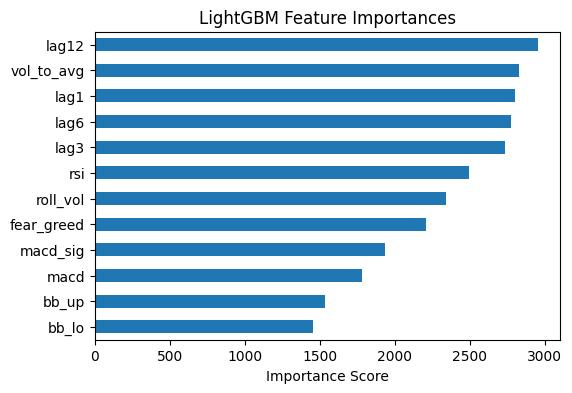

=== Multiclass + Fear&Greed Report ===
Accuracy: 0.7964
              precision    recall  f1-score   support

        Down       0.97      0.65      0.78      1818
      Stable       0.70      0.92      0.79      2037
          Up       0.82      0.80      0.81      1979

    accuracy                           0.80      5834
   macro avg       0.83      0.79      0.80      5834
weighted avg       0.83      0.80      0.80      5834


--- Test slice @ up=0.3, down=0.3 ---
signal
Sell    655
Buy     486
Hold     26
Name: count, dtype: int64

Final portfolio: $19096.94, trades: 691


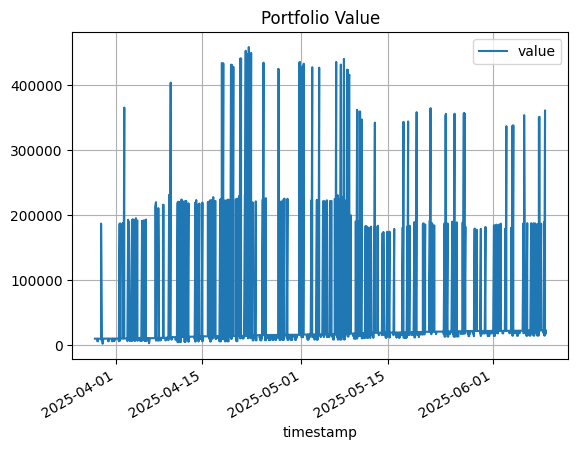


--- Full history @ up=0.3, down=0.3 ---

Final portfolio: $55919.15, trades: 3301


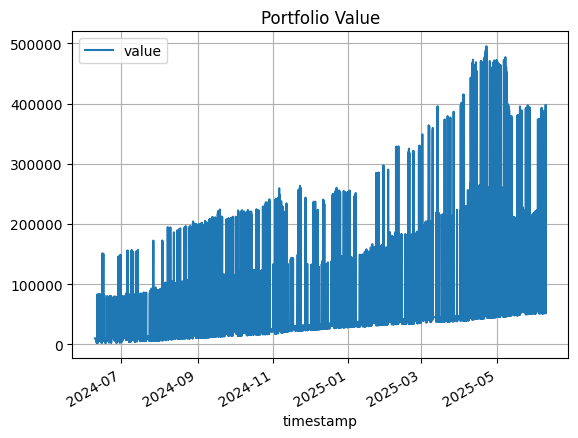


--- Next 3-Hour Signals ---
          timestamp  symbol     close  fear_greed  prob_up  prob_down signal
2025-06-09 15:00:00 BTCUSDT 107794.29        62.0 0.307203   0.306020   Sell
2025-06-09 15:00:00 ETHUSDT   2545.18        62.0 0.349836   0.297516    Buy


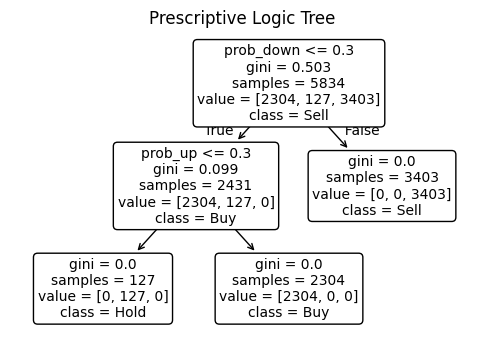

In [ ]:
import os
import requests
import warnings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import lightgbm as lgb

warnings.filterwarnings("ignore")
logging.getLogger("lightgbm").setLevel(logging.ERROR)

# ─── CONFIG ────────────────────────────────────────────────────────────────────
MIN_BARS     = 50
FNG_CACHE    = "fear_greed_cache.csv"
TRAIN_SPLIT  = 0.8
UP_THRESH    = 0.3
DOWN_THRESH  = 0.3
INITIAL_CASH = 10_000

# ─── FEAR & GREED ──────────────────────────────────────────────────────────────
def fetch_fear_greed(days=365, cache=FNG_CACHE):
    if os.path.exists(cache):
        fg = pd.read_csv(cache, parse_dates=["date"])
    else:
        resp = requests.get("https://api.alternative.me/fng/?limit=0&format=json")
        data = resp.json().get("data", [])
        fg = pd.DataFrame(data)
        fg["date"]       = pd.to_datetime(fg["timestamp"], unit="s")
        fg["fear_greed"] = fg["value"].astype(int)
        fg = fg[["date","fear_greed"]]
        fg.to_csv(cache, index=False)
    fg["date"] = fg["date"].dt.date
    cutoff    = pd.Timestamp.today().date() - pd.Timedelta(days=days)
    return fg[fg["date"]>=cutoff]

# ─── INDICATORS ───────────────────────────────────────────────────────────────
def calc_rsi(series, period=14):
    d  = series.diff()
    up = d.clip(lower=0).rolling(period).mean()
    dn = (-d.clip(upper=0)).rolling(period).mean().replace(0, np.nan)
    rs = up/dn
    return 100 - 100/(1+rs)

def calc_macd(series, fast=12, slow=26, sig=9):
    fe   = series.ewm(span=fast,adjust=False).mean()
    se   = series.ewm(span=slow,adjust=False).mean()
    macd = fe - se
    return macd, macd.ewm(span=sig,adjust=False).mean()

def calc_bb(series, window=20, n=2):
    ma = series.rolling(window).mean()
    sd = series.rolling(window).std()
    return ma+n*sd, ma-n*sd

# ─── DATA PREP ────────────────────────────────────────────────────────────────
def prepare_data(df):
    df = df.loc[:,~df.columns.duplicated()].copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df["date"]      = df["timestamp"].dt.date

    # pct change & lags
    df["pct_chg"] = df.groupby("symbol")["close"].pct_change()
    for lag in (1,3,6,12):
        df[f"lag{lag}"] = df.groupby("symbol")["pct_chg"].shift(lag)

    # volume vs avg & rolling vol
    df["vol20"]      = df.groupby("symbol")["volume"].transform(lambda x: x.rolling(20).mean())
    df["vol_to_avg"] = (df["volume"]/df["vol20"]).clip(0,5)
    df["roll_vol"]   = df.groupby("symbol")["pct_chg"].transform(lambda x: x.rolling(14).std())

    # indicators
    df["rsi"]      = df.groupby("symbol")["close"].transform(calc_rsi)
    macd_vals      = df.groupby("symbol")["close"].transform(lambda s: calc_macd(s)[0])
    sig_vals       = df.groupby("symbol")["close"].transform(lambda s: calc_macd(s)[1])
    df["macd"], df["macd_sig"] = macd_vals, sig_vals
    bb_up_vals, bb_lo_vals = (
        df.groupby("symbol")["close"].transform(lambda s: calc_bb(s)[0]),
        df.groupby("symbol")["close"].transform(lambda s: calc_bb(s)[1])
    )
    df["bb_up"], df["bb_lo"] = bb_up_vals, bb_lo_vals

    # target
    df["future_pct"] = df.groupby("symbol")["pct_chg"].shift(-1)
    df["target"]     = np.where(df["future_pct"]> 0.003, "Up",
                         np.where(df["future_pct"]< -0.003, "Down","Stable"))

    # fill
    cols = [c for c in df.columns if c not in ["timestamp","symbol","target","date"]]
    df[cols] = df.groupby("symbol")[cols].transform(lambda g: g.ffill().bfill())
    df.fillna(df.median(numeric_only=True), inplace=True)

    # merge Fear & Greed
    fg = fetch_fear_greed()
    df = df.merge(fg, on="date", how="left")
    df["fear_greed"] = df["fear_greed"].ffill().bfill().fillna(50)
    df.drop("date", axis=1, inplace=True)

    return df[df.groupby("symbol")["symbol"].transform("count")>=MIN_BARS]\
             .dropna(subset=["target"])

# ─── TRAIN & CALIBRATE ─────────────────────────────────────────────────────────
def train_multiclass(df):
    feats = ["lag1","lag3","lag6","lag12","roll_vol","vol_to_avg",
             "rsi","macd","macd_sig","bb_up","bb_lo","fear_greed"]

    df = df.sort_values("timestamp")
    X, y = df[feats].values, df["target"].values

    scaler = StandardScaler().fit(X)
    Xs     = scaler.transform(X)
    Xr, yr = SMOTETomek(random_state=42).fit_resample(Xs, y)

    base = lgb.LGBMClassifier(
        class_weight={"Up":2,"Stable":1,"Down":4},
        learning_rate=0.03, max_depth=6, n_estimators=400,
        random_state=42, verbose=-1
    )
    base.fit(Xr, yr)
    import pandas as pd
    import matplotlib.pyplot as plt

    # assume `base` is your trained LGBMClassifier (before calibration)
    importances = pd.Series(base.feature_importances_, index=feats)
    importances.sort_values().plot.barh(figsize=(6,4), title="LightGBM Feature Importances")
    plt.xlabel("Importance Score")
    plt.show()


    calib = CalibratedClassifierCV(base, cv=5, method="isotonic")
    calib.fit(Xs, y)

    preds = calib.predict(Xs)
    print("=== Multiclass + Fear&Greed Report ===")
    print(f"Accuracy: {accuracy_score(y, preds):.4f}")
    print(classification_report(y, preds, zero_division=0))

    return calib, scaler, feats

# ─── SIGNAL GENERATION ────────────────────────────────────────────────────────
def generate_signals(df, model, scaler, feats, up_t=UP_THRESH, down_t=DOWN_THRESH):
    out = df.copy()
    X   = scaler.transform(out[feats].values)
    p   = model.predict_proba(X)
    cls = model.classes_
    ui  = list(cls).index("Up")
    di  = list(cls).index("Down")

    out["prob_up"]   = p[:,ui]
    out["prob_down"] = p[:,di]
    out["signal"]    = "Hold"
    out.loc[out["prob_down"]>down_t,    "signal"] = "Sell"
    out.loc[(out["signal"]=="Hold") & (out["prob_up"]>up_t), "signal"] = "Buy"
    return out[["timestamp","symbol","close","fear_greed","prob_up","prob_down","signal"]]

# ─── NEXT‐3H HELPER ───────────────────────────────────────────────────────────
def next_3h_signals(df, model, scaler, feats, up_t=UP_THRESH, down_t=DOWN_THRESH):
    latest = df.groupby("symbol").tail(1).copy()
    latest["timestamp"] += pd.Timedelta(hours=3)
    for lag in (1,3,6,12):
        latest[f"lag{lag}"] = df.groupby("symbol")["pct_chg"].shift(lag-1).tail(len(latest)).values
    return generate_signals(latest, model, scaler, feats, up_t, down_t)

# ─── BACKTEST ─────────────────────────────────────────────────────────────────
def backtest(sigs):
    cash, alloc, pos = INITIAL_CASH, INITIAL_CASH*0.4, {s:0 for s in sigs["symbol"].unique()}
    buyp, buyt, trades, port = {}, {}, [], []

    for _, r in sigs.sort_values("timestamp").iterrows():
        ts, sym, price, sig = r["timestamp"], r["symbol"], r["close"], r["signal"]
        # auto‐exit SL/TP/TO
        if pos[sym]>0:
            bp, bt = buyp[sym], buyt[sym]
            if price<bp*0.985 or price>bp*1.035 or (ts-bt).total_seconds()/3600>=6:
                cash += pos[sym]*price*0.999
                trades.append((ts,sym,"AutoSell",price,pos[sym]))
                pos[sym]=0

        if sig=="Buy" and cash>=alloc and pos[sym]*price<INITIAL_CASH*0.7:
            qty = alloc/price*0.999
            pos[sym]+=qty; buyp[sym],buyt[sym]=price,ts
            cash-=qty*price; trades.append((ts,sym,"Buy",price,qty))
        elif sig=="Sell" and pos[sym]>0:
            cash+=pos[sym]*price*0.999
            trades.append((ts,sym,"Sell",price,pos[sym])); pos[sym]=0

        total = cash + sum(pos[k]*price for k in pos)
        port.append((ts,total))

    trades_df = pd.DataFrame(trades,columns=["timestamp","symbol","action","price","units"])
    port_df   = pd.DataFrame(port,columns=["timestamp","value"])
    print(f"\nFinal portfolio: ${port_df['value'].iloc[-1]:.2f}, trades: {len(trades_df)}")
    port_df.plot(x="timestamp",y="value",title="Portfolio Value",grid=True)
    plt.show()
    return trades_df, port_df

# ─── MAIN ─────────────────────────────────────────────────────────────────────
if __name__=="__main__":
    raw = pd.read_csv("crypto_dashboard_3h_1year.csv")
    print(f"Loaded {len(raw)} rows, symbols={raw['symbol'].nunique()}")
    print(f"Date range: {raw['timestamp'].min()} → {raw['timestamp'].max()}")

    data  = prepare_data(raw)
    model, scaler, feats = train_multiclass(data)

    # test-slice
    split = int(len(data)*TRAIN_SPLIT)
    sigs_test = generate_signals(data.iloc[split:], model, scaler, feats)
    print(f"\n--- Test slice @ up={UP_THRESH}, down={DOWN_THRESH} ---")
    print(sigs_test["signal"].value_counts())
    backtest(sigs_test)

    # full-history
    sigs_all = generate_signals(data, model, scaler, feats)
    print(f"\n--- Full history @ up={UP_THRESH}, down={DOWN_THRESH} ---")
    backtest(sigs_all)

    # create validation dataset
    validation_df = data[[
        "timestamp","symbol","future_pct","fear_greed","roll_vol",
        "lag1","lag3","lag6","lag12"
    ]].copy()
    validation_df = validation_df.merge(
        sigs_all[["timestamp","symbol","signal","prob_up","prob_down"]],
        on=["timestamp","symbol"], how="inner"
    ).dropna(subset=["future_pct","signal"])
    validation_df.to_csv("model_validation_dataset.csv", index=False)

    # next-3h
    next3 = next_3h_signals(data, model, scaler, feats)
    print("\n--- Next 3-Hour Signals ---")
    print(next3.to_string(index=False))

    # logic tree
    df2 = sigs_all[["prob_down","prob_up","signal"]].dropna()
    tree = DecisionTreeClassifier(max_depth=2).fit(df2[["prob_down","prob_up"]], df2["signal"])
    plt.figure(figsize=(6,4))
    plot_tree(tree,
              feature_names=["prob_down","prob_up"],
              class_names=tree.classes_,
              rounded=True, fontsize=10)
    plt.title("Prescriptive Logic Tree")
    plt.show()



Final portfolio: $55919.15, trades: 3301


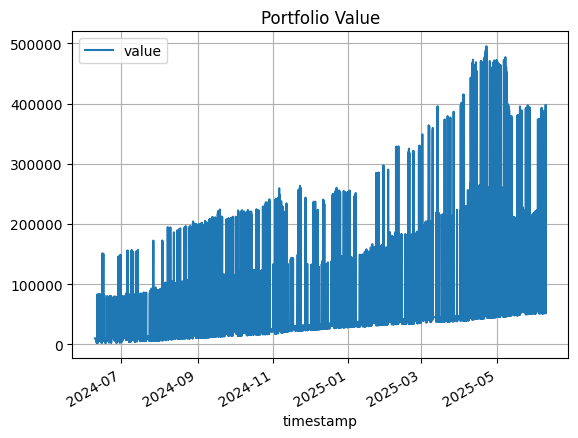


Final portfolio: $5461.50, trades: 2545


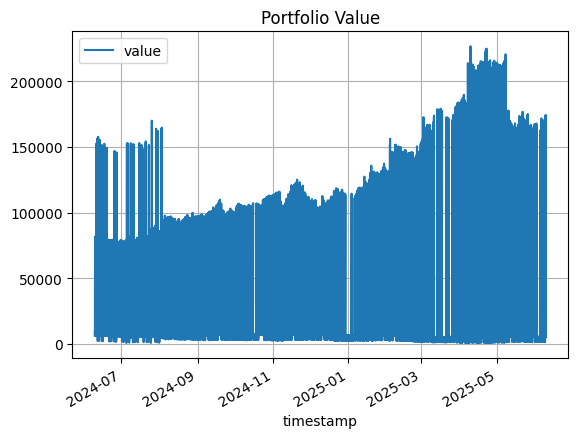


Final portfolio: $1946.86, trades: 2680


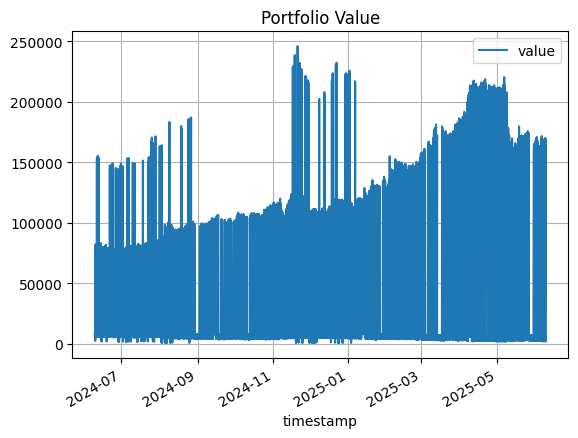


Final portfolio: $4975.89, trades: 2597


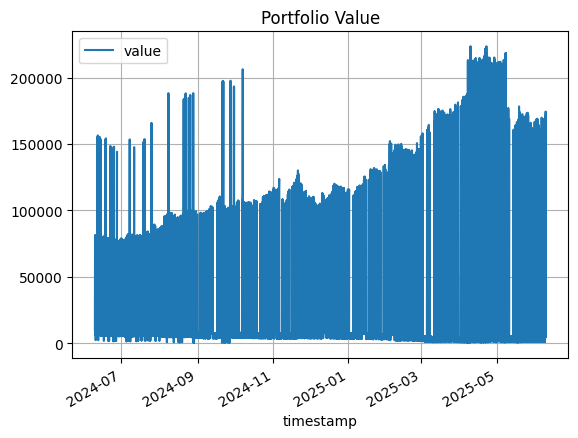


Final portfolio: $3940.22, trades: 2033


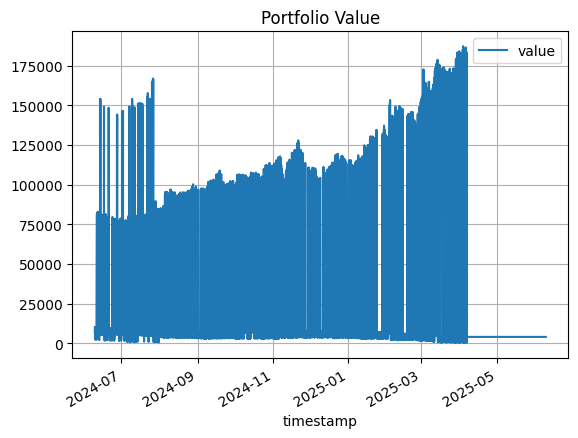


Final portfolio: $3897.44, trades: 2071


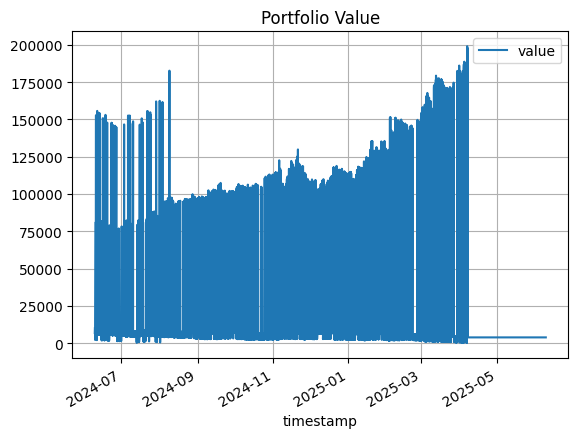


Final portfolio: $5315.37, trades: 2614


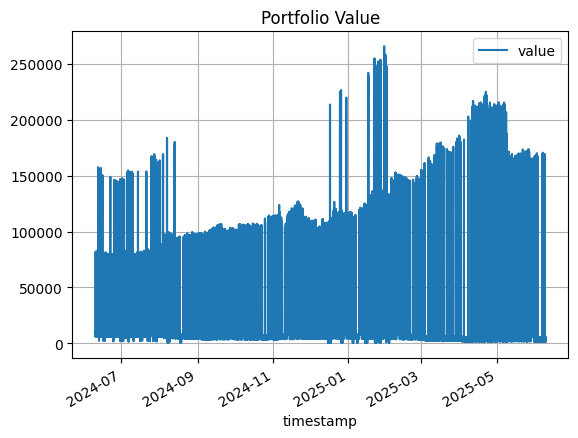


Final portfolio: $4608.14, trades: 2512


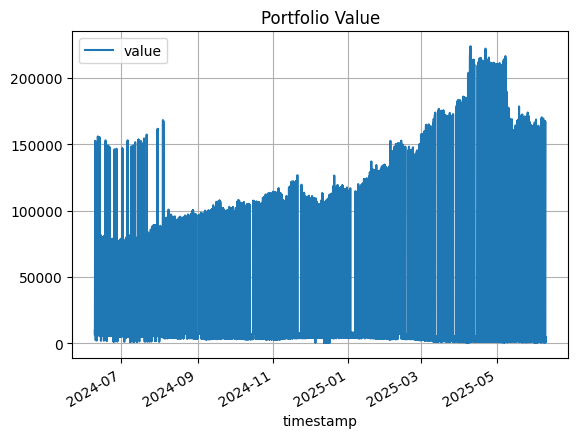


Final portfolio: $2973.54, trades: 2817


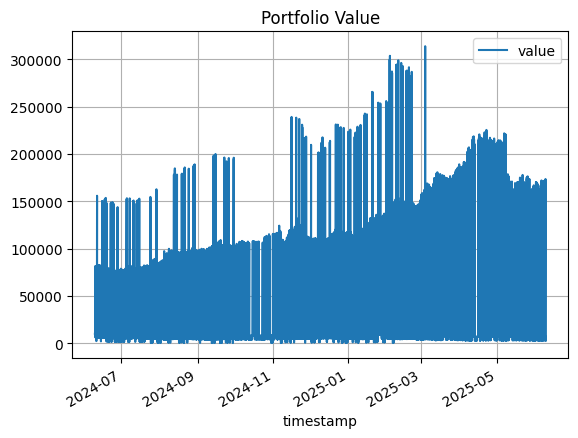


Final portfolio: $3190.45, trades: 2499


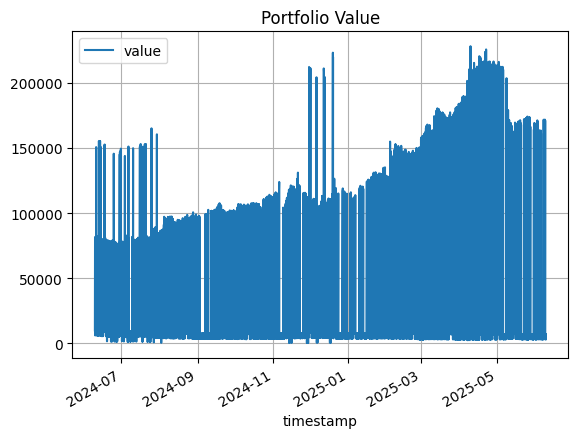


Final portfolio: $5886.06, trades: 2448


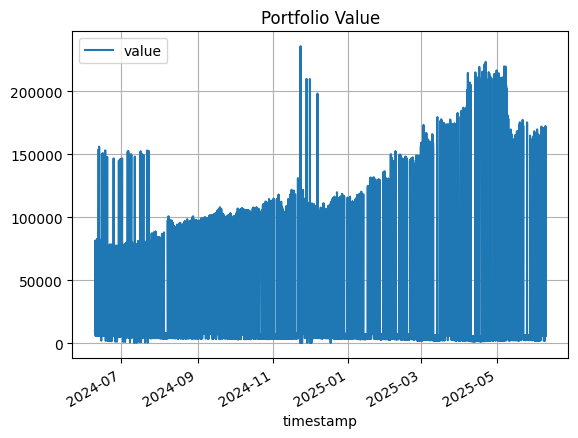


Portfolio Comparison:
 Model value: $55919.15
 Random avg : $4219.55
 T-statistic: -130.1466, p-value: 0.0000



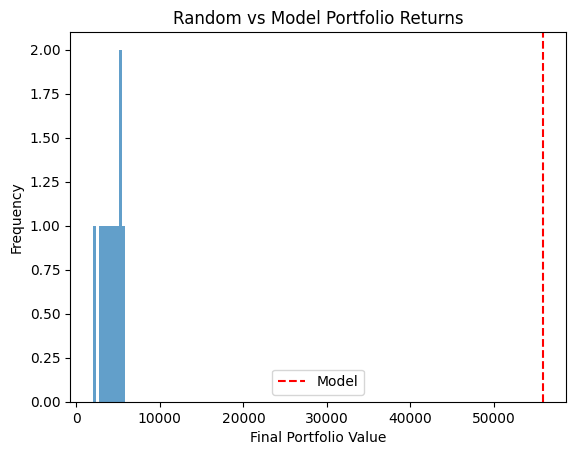

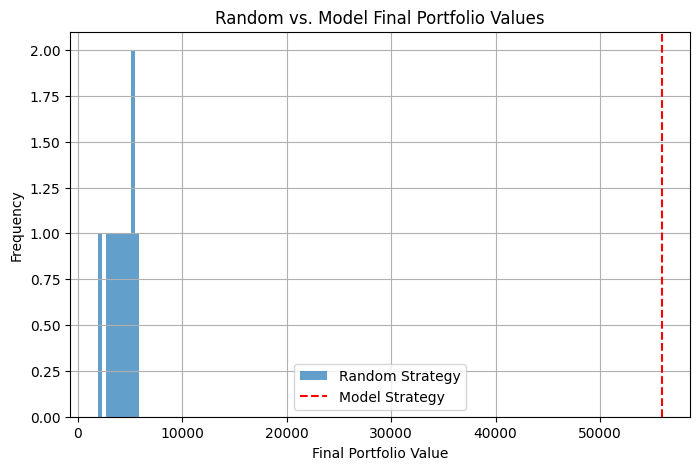

In [ ]:
##H1--
# ─── EVALUATE MODEL PORTFOLIO ──────────────────────────────────────────────────
# Generate full-history signals and backtest to get the model's final portfolio value
sigs_all = generate_signals(data, model, scaler, feats)
_, model_port = backtest(sigs_all)
model_value = model_port["value"].iloc[-1]

# ─── VALIDATION: RANDOM BASELINE ───────────────────────────────────────────────
# Run 10 random‐signal simulations and collect their final values
random_final_values = evaluate_strategy_vs_random(
    sigs_all,
    model_value,
    n_runs=10
)

# ─── VISUALIZE COMPARISON ──────────────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(random_final_values, bins=10, alpha=0.7, label="Random Strategy")
plt.axvline(model_value, color="red", linestyle="--", label="Model Strategy")
plt.title("Random vs. Model Final Portfolio Values")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()



📊 H2: Signal Type vs Future Return
Buy mean:  0.0047
Sell mean: -0.0030
Hold mean: -0.0003
H-statistic: 922.2079, p-value: 0.0000


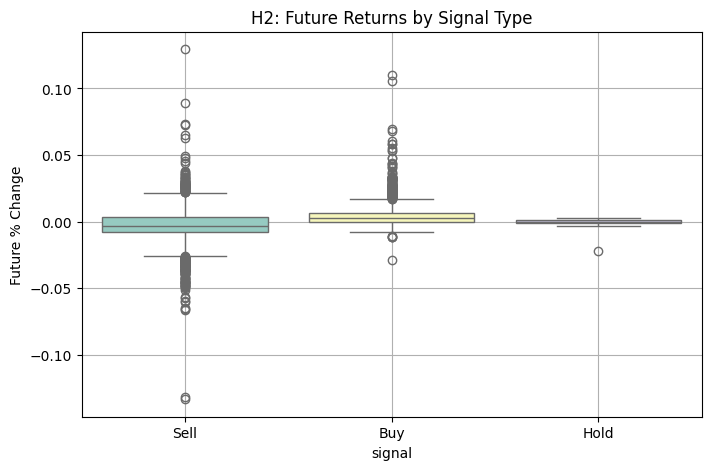

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# ─── LOAD VALIDATION DATA ───────────────────────────────────────────────────────
df = pd.read_csv("model_validation_dataset.csv")

# ─── H2: Signal Type vs Future Return ───────────────────────────────────────────
# Extract returns per signal class
buy_returns  = df[df["signal"] == "Buy"]["future_pct"]
sell_returns = df[df["signal"] == "Sell"]["future_pct"]
hold_returns = df[df["signal"] == "Hold"]["future_pct"]

# Perform Kruskal–Wallis test (non-parametric ANOVA)
h_stat, p_val_h2 = kruskal(buy_returns, sell_returns, hold_returns)

# Print results
print("\n📊 H2: Signal Type vs Future Return")
print(f"Buy mean:  {buy_returns.mean():.4f}")
print(f"Sell mean: {sell_returns.mean():.4f}")
print(f"Hold mean: {hold_returns.mean():.4f}")
print(f"H-statistic: {h_stat:.4f}, p-value: {p_val_h2:.4f}")

# ─── VISUALIZATION ─────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 5))
sns.boxplot(x="signal", y="future_pct", data=df, palette="Set3")
plt.title("H2: Future Returns by Signal Type")
plt.ylabel("Future % Change")
plt.grid(True)
plt.show()